# Urbanization Trends Analysis using NASA's Black Marble VNP46A4 Data

In [1]:
# Import packages
import os
from datetime import datetime as dt
from enum import Enum
import h5py
import numpy as np
import matplotlib.pyplot as plt

## Obtain list of all HDF5 files

In [2]:
filepaths = []
DATA_DIR = "./data/yearly/"
for filepath in os.listdir(DATA_DIR):
    if filepath.endswith(".h5"):
        filepaths.append(os.path.join(DATA_DIR, filepath))

In [3]:
def get_file_info(filepath):
    """Returns a dictionary containing the file's metadata.

    Filepaths are expected to be in the format:
    VNP46AX.AYYYYDDD.hXXvYY.CCC.YYYYDDDHHMMSS.h5
    """
    filename = os.path.basename(filepath)
    data = filename.split(".")
    short_name = data[0]
    acquisition_date = dt.strptime(data[1], "A%Y%j").strftime("%Y-%m-%d")
    tile_id = data[2]
    collection_version = data[3]
    production_date = dt.strptime(data[4], "%Y%j%H%M%S").strftime("%Y-%m-%d")

    return {
        "filename": filename,
        "short_name": short_name,
        "acquisition_date": acquisition_date,
        "tile_id": tile_id,
        "collection_version": collection_version,
        "production_date": production_date,
    }


get_file_info(filepaths[0])

{'filename': 'VNP46A4.A2012001.h30v07.001.2021125045659.h5',
 'short_name': 'VNP46A4',
 'acquisition_date': '2012-01-01',
 'tile_id': 'h30v07',
 'collection_version': '001',
 'production_date': '2021-05-05'}

## Define constants

Since the Philippines does not experience snow, we will use the `NearNadir_Composite_Snow_Free` dataset. This is a composite of all the images taken during the dry season. The `Land_Water_Mask` will be used to mask out the water bodies.

In [4]:
# Define constants for HDF5 datasets
BASE_PATH = "HDFEOS/GRIDS/VIIRS_Grid_DNB_2d/Data Fields/"
RADIANCE_DATASET = BASE_PATH + "NearNadir_Composite_Snow_Free"
LAND_WATER_MASK_DATASET = BASE_PATH + "Land_Water_Mask"
LATITUDE_DATASET = BASE_PATH + "lat"
LONGITUDE_DATASET = BASE_PATH + "lon"

# Define constants for land/water mask values
Mask = Enum(
    "MASK",
    ["LAND_AND_DESERT", "LAND_ONLY", "INLAND_WATER", "SEAWATER", "COASTAL"],
)

## Read data from HDF5 files

### Define functions for reading data

In [5]:
def get_data(filepath, dataset, top=None, left=None, bottom=None, right=None):
    """Returns a subset of the data from the given dataset in the given file."""
    with h5py.File(filepath, "r") as h5_file:
        data = h5_file[dataset][left:right, top:bottom]

        # Normalize data in land/water mask
        if dataset == LAND_WATER_MASK_DATASET:
            data[data == 255] = Mask.SEAWATER.value

    return data

In [6]:
def get_max_radiance(radiance_data, mask_data):
    return np.max(
        radiance_data[
            (mask_data == Mask.LAND_ONLY.value)
            | (mask_data == Mask.LAND_AND_DESERT.value)
        ]
    )

In [7]:
def get_mean_radiance(radiance_data, mask_data):
    return np.mean(
        radiance_data[
            (mask_data == Mask.LAND_ONLY.value)
            | (mask_data == Mask.LAND_AND_DESERT.value)
        ]
    )

### Display a single HDF5 file

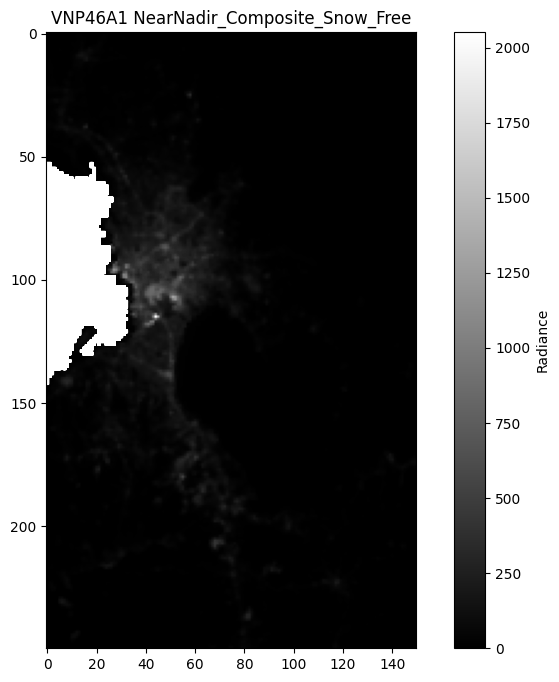

In [8]:
# Define bounding box for the area of interest
box = {"top": 200, "left": 1200, "bottom": 350, "right": 1450}

# Get radiance data
radiance_data = get_data(filepaths[0], RADIANCE_DATASET, **box)
mask_data = get_data(filepaths[0], LAND_WATER_MASK_DATASET, **box)

# Display the data using matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(
    radiance_data,
    cmap="gray",
    vmin=0,
    vmax=get_max_radiance(radiance_data, mask_data),
)
plt.colorbar(label="Radiance")
plt.title("VNP46A1 NearNadir_Composite_Snow_Free")
plt.show()

### Display a grid of HDF5 files

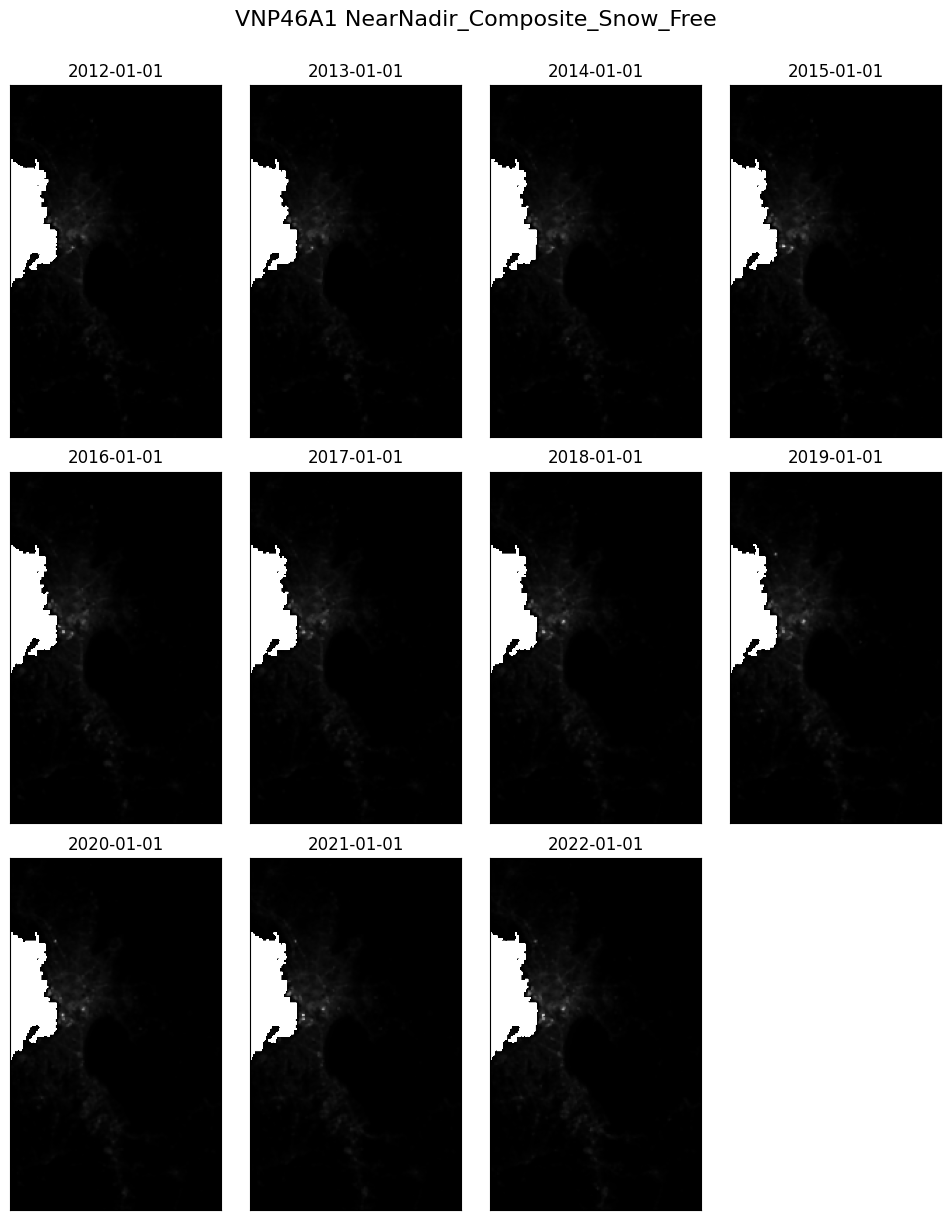

In [9]:
fig, axs = plt.subplots(3, 4, figsize=(20, 15), sharex=True, sharey=True)
fig.suptitle(
    "VNP46A1 NearNadir_Composite_Snow_Free", fontsize=16, x=0.26, y=0.9
)
fig.delaxes(axs[2, 3])

# Get the data for each year
data = [
    (
        get_data(filepath, RADIANCE_DATASET, **box),
        get_data(filepath, LAND_WATER_MASK_DATASET, **box),
    )
    for filepath in filepaths
]

# Get the maximum radiance value for the entire dataset
max_radiance = max(
    get_max_radiance(radiance_data, mask_data)
    for radiance_data, mask_data in data
)

# Get the year acquired for each file
years_acquired = [
    get_file_info(filepath)["acquisition_date"] for filepath in filepaths
]

for subplot, (radiance_data, mask_data), year_acquired in zip(
    axs.flat, data, years_acquired
):
    subplot.imshow(radiance_data, cmap="gray", vmin=0, vmax=max_radiance)
    subplot.set_title(year_acquired, fontsize=12)
    subplot.set_xticks([])
    subplot.set_yticks([])

plt.subplots_adjust(
    left=0.02, right=0.5, bottom=0.1, top=0.85, wspace=0, hspace=0.1
)
plt.show()

# Show trends of night lights in Manila, Philippines

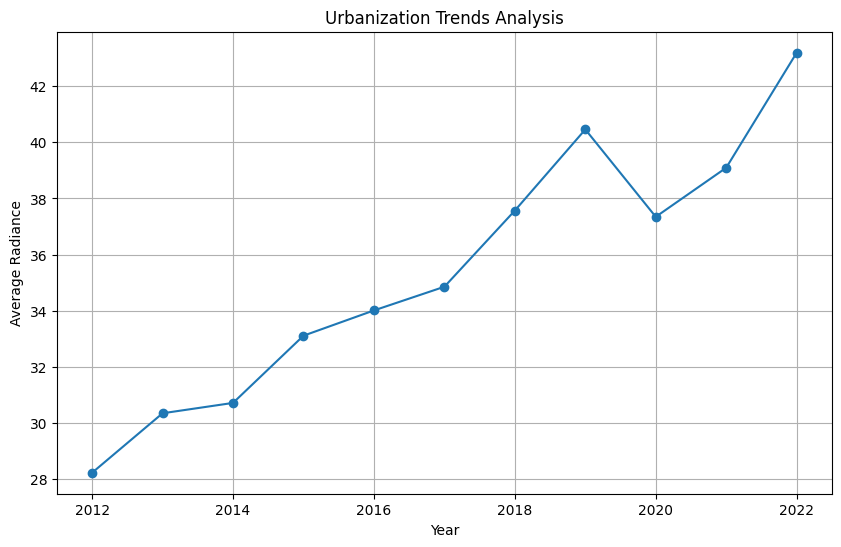

In [10]:
radiance_trends = [
    get_mean_radiance(
        get_data(filepath, RADIANCE_DATASET, **box),
        get_data(filepath, LAND_WATER_MASK_DATASET, **box),
    )
    for filepath in filepaths
]

plt.figure(figsize=(10, 6))
plt.plot(range(2012, 2023), radiance_trends, marker="o")
plt.title("Urbanization Trends Analysis")
plt.xlabel("Year")
plt.ylabel("Average Radiance")
plt.grid(True)
plt.show()